In [1]:
from data_pre_processing import *
from pair_finder import *
from back_tester import *
import itertools

# Get Data 
---

In [2]:

#prices = pd.read_csv("binance_data/Staked_ETH_Bybit/merged_closing_prices.csv", index_col=0, parse_dates=True)

#prices = pd.read_csv("binance_data/From_Paper/2023/1m/merged_From_Paper_closing_prices_OCT_NOV.csv", index_col=0, parse_dates=True)

#BTC and WBTC
#-------------------------------------------
#prices = pd.read_csv("binance_data/Wrapped BTC/2024/30m/merged_closing_prices.csv", index_col=0, parse_dates=True)

prices = pd.read_csv("binance_data/Wrapped BTC/2024/1m/merged_closing_prices.csv", index_col=0, parse_dates=True)


# #SOL and BNSOL
# #-------------------------------------------
# prices = pd.read_csv('binance_data/SOL_and_BNSOL/2025/1m/merged_closing_prices.csv', index_col=0, parse_dates=True)

#ETH and WBTC
#-------------------------------------------
#prices = pd.read_csv('binance_data/ETH_and_WBETH/2024/1m/merged_closing_prices.csv', index_col=0, parse_dates=True)

In [3]:
prices

,BTC/USDT_2024_1m,WBTC/USDT_2024_1m
timestamp,,
2024-01-01 00:00:00,42298.61,42247.70
2024-01-01 00:01:00,42320.00,42266.25
2024-01-01 00:02:00,42325.50,42266.25
2024-01-01 00:03:00,42367.99,42287.75
2024-01-01 00:04:00,42397.23,42333.24
...,...,...
2024-12-31 23:55:00,93667.52,93463.52
2024-12-31 23:56:00,93636.37,93479.47
2024-12-31 23:57:00,93616.04,93470.69


In [4]:
#get prices for dates greater than or equal to 2024-01-01 16:30:00	

#prices = prices.loc[prices.index >= "2024-01-01 16:30:00"]

# Trading simulation
---

* ## In-Sample Testing

In [5]:
# #XVS/USDT_2024_30m & QI/USDT_2024_30m


# crypto_1 = prices.columns[0]
# crypto_2 = prices.columns[1]

# cointegrated_pairs = [(crypto_1,
#   crypto_2,
#   0.731393,
#   0.8501886494196308,
#   0.22)]

In [6]:
#Params:
window_size = 1440
entry_threshold= 3
exit_threshold= 0
stop_loss_threshold= 5

In [7]:
sym1, sym2 = prices.columns
print(f"\nTesting strategy on pair: {sym1} and {sym2} ...")
S1 = prices[sym1]
S2 = prices[sym2]

# Compute the spread series and beta_series 
spread_series, beta_series, alpha_series = compute_spread_series(S1, S2, window_size)
#print(f"Hedge ratio (beta) for {sym1} ~ {sym2}: {beta:.4f}")

# Compute rolling z-score using the provided helper function.
zscore_series, rolling_mean, rolling_std = compute_rolling_zscore(spread_series, window_size)

# Generate trading signals (positions) based on the spread's z-score
positions, trade_entries, trade_exits = backtest_pair_rolling(spread_series,S1,S2,zscore_series, entry_threshold, exit_threshold, stop_loss_threshold)




Testing strategy on pair: BTC/USDT_2024_1m and WBTC/USDT_2024_1m ...
Total trades closed: 13211 (Wins=11444, Losses=1767)
Win rate: 0.87


(array([2.00000e+00, 0.00000e+00, 0.00000e+00, 2.00000e+00, 6.00000e+00,
        3.40000e+01, 1.27000e+02, 6.20000e+02, 3.73200e+03, 2.37580e+04,
        1.09993e+05, 2.08362e+05, 1.35932e+05, 3.47250e+04, 5.47800e+03,
        9.27000e+02, 2.23000e+02, 7.90000e+01, 4.40000e+01, 2.40000e+01,
        3.00000e+00, 5.00000e+00, 2.00000e+00, 2.00000e+00, 0.00000e+00,
        0.00000e+00, 1.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([-11.98012448, -10.94790456,  -9.91568465,  -8.88346474,
         -7.85124483,  -6.81902491,  -5.786805  ,  -4.75458509,
         -3.72236518,  -2.69014526,  -1.65792535,  -0.62570544,
          0.40651447,   1.43873439,   2.4709543 ,   3.50317421,
          4.53539412,   5.56761403,   6.59983395,   7.63205386,
          8.66427377,   9.69649368,  10.7287136 ,  11.76093351,
         12.79315342,  13.82537333,  14.85759325,  15.88981316,
         16.92203307,  17.95425298,  18.9864729 ]),
 <BarContainer object of 30 artists>)

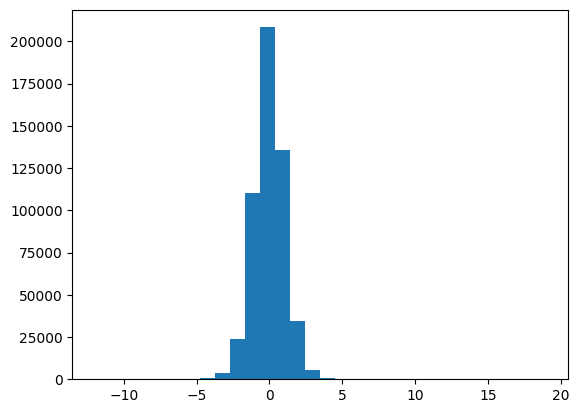

In [8]:
plt.hist(zscore_series, bins=30)

In [9]:
# #Compute normalised difference between the two prices
# normalised_abs_diff = np.abs((S1 - S2) / (S1 + S2))

# #Compute the average normalised difference
# np.mean(normalised_abs_diff)

In [10]:
# #SETH and ETH Distance: 0.0003968226419110906

# s_eth_distance = 0.0003968226419110906
# w_bitcoin_distance = 0.0006442955592394416

# percentage = s_eth_distance/w_bitcoin_distance * 100
# percentage


In [11]:
# sym1

In [12]:
# price_changes_S1_non_zero = [x for x in price_changes_S1 if x != 0]
# price_changes_S2_non_zero = [x for x in price_changes_S2 if x != 0]

# len(price_changes_S2_non_zero)

In [13]:
S1

timestamp
2024-01-01 00:00:00    42298.61
2024-01-01 00:01:00    42320.00
2024-01-01 00:02:00    42325.50
2024-01-01 00:03:00    42367.99
2024-01-01 00:04:00    42397.23
                         ...   
2024-12-31 23:55:00    93667.52
2024-12-31 23:56:00    93636.37
2024-12-31 23:57:00    93616.04
2024-12-31 23:58:00    93600.00
2024-12-31 23:59:00    93576.00
Name: BTC/USDT_2024_1m, Length: 526962, dtype: float64

In [30]:
initial_capital = 10_000.0
#tx_cost= 0.00031 #0.031% transaction cost
tx_cost= 0.00025 #0.025% transaction cost #Binance level 5 Maker Cost

trade_profits, cumulative_profit_series, entry_times, exit_times = simulate_strategy_trade_pnl(trade_entries, trade_exits, initial_capital, beta_series, tx_cost)

Total trades: 13211
Number of profitable trades (proft > 0): 10551
Number of non-profitable trades (proft < 0): 2660
Total return €: 43370.23
Total return %: 433.70%
Long spread losses: 1369, Short spread losses: 1291
Number of Dual-leg profitable trades: 5437
Dual leg trade profit rate: 41.16%


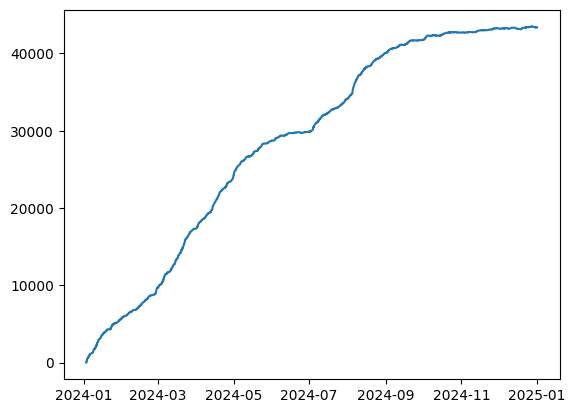

In [15]:
plt.plot(cumulative_profit_series)

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 1.000e+00, 1.000e+00, 5.000e+00,
        1.600e+01, 2.100e+01, 3.900e+01, 5.400e+01, 1.360e+02, 2.330e+02,
        3.970e+02, 4.830e+02, 2.330e+02, 7.800e+01, 3.500e+01, 1.740e+02,
        8.520e+02, 1.481e+03, 1.533e+03, 1.537e+03, 1.352e+03, 1.199e+03,
        9.580e+02, 6.860e+02, 4.640e+02, 3.470e+02, 2.820e+02, 1.610e+02,
        1.330e+02, 9.600e+01, 5.400e+01, 4.700e+01, 3.500e+01, 2.400e+01,
        1.600e+01, 1.200e+01, 7.000e+00, 6.000e+00, 2.000e+00, 2.000e+00,
        3.000e+00, 1.000e+00, 4.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+0

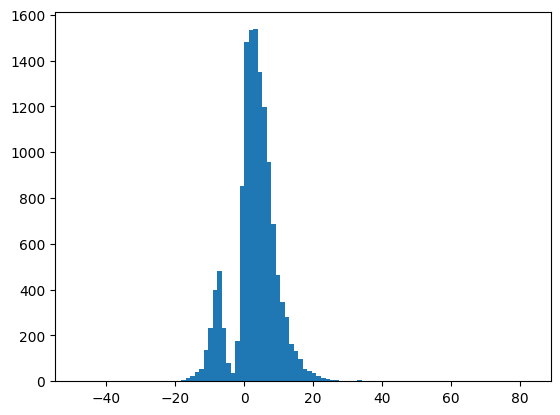

In [16]:
plt.hist(trade_profits, bins=100)

In [17]:
#Filter for negative values

trade_profits_neg = [x for x in trade_profits if x < 0]
print(f"Average trade loss:  € {np.mean(trade_profits_neg)}")

trade_profits_pos = [x for x in trade_profits if x > 0]
print(f"Average trade win:  € {np.mean(trade_profits_pos)}")

print("Number of negative profits(profits that were less than the transaction cost): ", len(trade_profits_neg))
print("Number of positive profits (profits that were greater than the transaction cost): ", len(trade_profits_pos))



Average trade loss:  € -5.646388446635429
Average trade win:  € 5.534037238404966
Number of negative profits(profits that were less than the transaction cost):  2660
Number of positive profits (profits that were greater than the transaction cost):  10551


In [18]:
# #Calculate returns based on the trade profits
# trade_profits = np.array(trade_profits)
# returns = trade_profits/initial_capital * 100

# #Plot the returns
# plt.hist(returns, bins=50, edgecolor='black')
# plt.xlabel('Returns (%)')   
# plt.ylabel('Frequency')
# plt.title(f'Returns Distribution for Pair {sym1} and {sym2}') 

In [19]:
# #Calculate percentage price changes for each asset
# price_changes_S1 = np.array(price_changes_S1)

In [20]:
# #Obtain non-zero price changes
# price_changes_S1_non_zero = [x for x in price_changes_S1 if x != 0]
# price_changes_S2_non_zero = [x for x in price_changes_S2 if x != 0]

# #Convert price changes to percentage
# price_changes_S1_non_zero_percent = [(x*100) for x in price_changes_S1_non_zero]
# price_changes_S2_non_zero_percent = [(x*100) for x in price_changes_S2_non_zero]

# #Print average price changes
# print(f"Average price change S1: {np.mean(price_changes_S1_non_zero_percent)} %", f"Average price change S1: {np.mean(price_changes_S2_non_zero_percent)} %")
# print(f"Number of trades: {len(price_changes_S1_non_zero)}")

In [21]:
# percentage_return = cumulative_profit_series[-1]/initial_capital * 100
# print(f"Percentage return: {percentage_return:.2f} %")


# #PROFIT SHOULD BE 0.15 EUR

# plt.figure(figsize=(10,6))
# plt.plot(cumulative_profit_series)
# plt.title('Cumulative PnL')
# plt.xlabel('Time')
# plt.ylabel('PnL (EUR)')
# plt.show()

Number of trade entries: 9
Number of trade exits: 9
Total paired trades: 9
Trades in window:
Trade 1 : 2024-02-01 00:02:00 to 2024-02-01 00:04:00 (win)
Trade 2 : 2024-02-01 00:21:00 to 2024-02-01 00:28:00 (win)
Trade 3 : 2024-02-01 00:29:00 to 2024-02-01 00:30:00 (loss)
Trade 4 : 2024-02-01 00:37:00 to 2024-02-01 00:41:00 (win)
Trade 5 : 2024-02-01 00:43:00 to 2024-02-01 00:45:00 (loss)
Trade 6 : 2024-02-01 00:54:00 to 2024-02-01 00:55:00 (loss)
Trade 7 : 2024-02-01 01:13:00 to 2024-02-01 01:19:00 (win)
Trade 8 : 2024-02-01 01:20:00 to 2024-02-01 01:34:00 (win)
Trade 9 : 2024-02-01 01:41:00 to 2024-02-01 01:42:00 (loss)


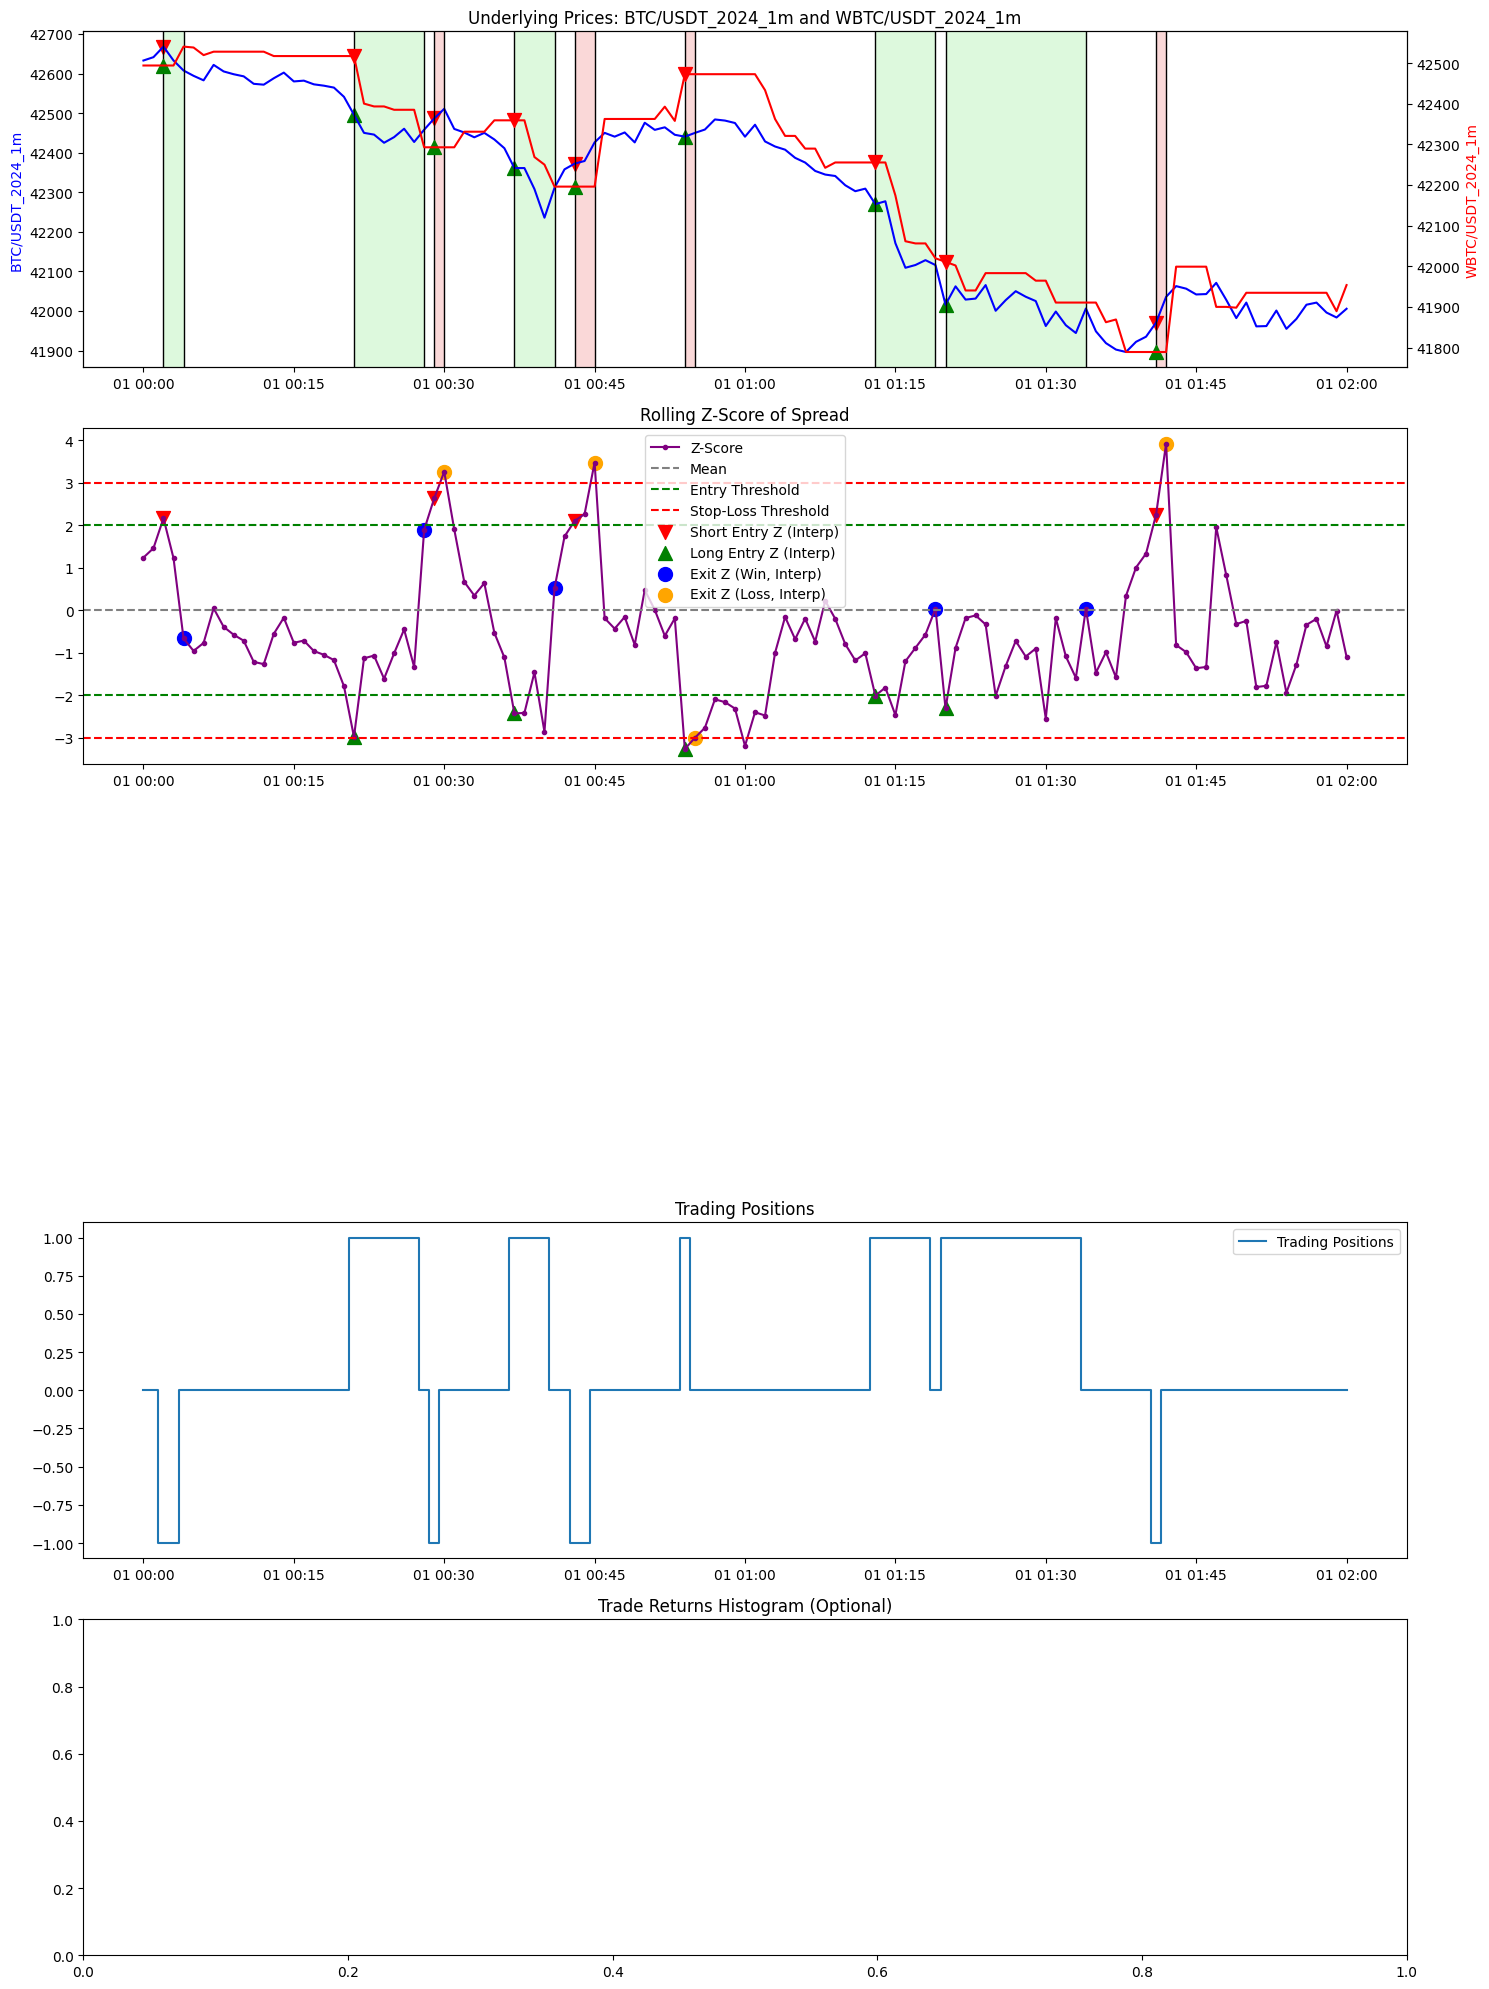

In [22]:
#Plot trading simulation
window_start = pd.to_datetime('2024-02-01 00:00:00')
window_end = pd.to_datetime('2024-02-01 2:00:00')


# window_start = pd.to_datetime('2024-03-05 08:00:00')
# window_end = pd.to_datetime('2024-03-08 15:00:00')

# window_start = None
# window_end = None

#NOTE THAT THE TIMES ON THE X AXIS SHOW THE HOURS AND MINUTES

plot_trading_simulation(
    S1, 
    S2, 
    sym1, 
    sym2, 
    zscore_series, 
    positions, 
    entry_threshold,
    stop_loss_threshold,
    trade_entries=trade_entries,  # list of dicts: { 'time', 'S1', 'S2', 'z', 'position' }
    trade_exits=trade_exits,    # list of dicts: { 'time', 'S1', 'S2', 'z', 'exit_type' }
    window_start=window_start,
    window_end=window_end
)



In [23]:
#Zip trade entries and exits
trade_entries_exits = list(zip(trade_entries, trade_exits))
trade_entries_exits

[({'time': Timestamp('2024-01-03 01:08:00'),
   'S1': np.float64(45207.57),
   'S2': np.float64(45065.2),
   'z': np.float64(2.058657003954451),
   'position': -1},
  {'time': Timestamp('2024-01-03 01:19:00'),
   'S1': np.float64(45174.01),
   'S2': np.float64(45143.96),
   'z': np.float64(-0.00455559223877659),
   'exit_type': 'win'}),
 ({'time': Timestamp('2024-01-03 10:15:00'),
   'S1': np.float64(45380.95),
   'S2': np.float64(45261.77),
   'z': np.float64(2.407803631186041),
   'position': -1},
  {'time': Timestamp('2024-01-03 10:16:00'),
   'S1': np.float64(45361.1),
   'S2': np.float64(45384.85),
   'z': np.float64(-0.5865693582497318),
   'exit_type': 'win'}),
 ({'time': Timestamp('2024-01-03 11:30:00'),
   'S1': np.float64(44384.36),
   'S2': np.float64(44481.86),
   'z': np.float64(-2.4092324969122347),
   'position': 1},
  {'time': Timestamp('2024-01-03 11:31:00'),
   'S1': np.float64(44407.68),
   'S2': np.float64(44377.04),
   'z': np.float64(0.4371469030441821),
   'exit_

In [24]:
z = 0.1

if z < -0:
    print("Short")

In [25]:


# #Get prices at the start and end of the first trade
# S1_price_start = S1[entry_indices]
# S2_price_start = S2[entry_indices]

# S1_price_end = S1.loc[exit_indices]
# S2_price_end = S2.loc[exit_indices]


# #Calculate the price changes by converting the series to numpy arrays
# S1_price_start = S1_price_start.to_numpy()
# S2_price_start = S2_price_start.to_numpy()

# S1_price_end = S1_price_end.to_numpy()
# S2_price_end = S2_price_end.to_numpy()

# print("BEFORE ALIGNMENT")

# #Make sure the arrays have the same shape
# print(S1_price_start.shape)
# print(S2_price_start.shape)


# print(S1_price_end.shape)
# print(S2_price_end.shape)


# if S1_price_start.shape > S1_price_end.shape:
#     S1_price_start = S1_price_start[:len(S1_price_end)]

# if S2_price_start.shape > S2_price_end.shape:
#     S2_price_start = S2_price_start[:len(S2_price_end)]
 
# print("AFTER ALIGNMENT")

# #Make sure the arrays have the same shape
# print(S1_price_start.shape)
# print(S2_price_start.shape)

# print(S1_price_end.shape)
# print(S2_price_end.shape)

# #Get the price changes
# S1_price_change = S1_price_end - S1_price_start
# S2_price_change = S2_price_end - S2_price_start

# #Get percentage price changes
# S1_price_change_percent = S1_price_change/S1_price_start * 100
# S2_price_change_percent = S2_price_change/S2_price_start * 100

# #Get absolute percentage price changes
# S1_price_change_percent_abs = np.abs(S1_price_change_percent)
# S2_price_change_percent_abs = np.abs(S2_price_change_percent)


# print(f"Average absolute S1 price change percent: {np.mean(S1_price_change_percent_abs):.2f}%")
# print(f"Average absolute S2 price change percent: {np.mean(S2_price_change_percent_abs):.2f}%")

# print(f"Average of average absolute price changes: {(np.mean(S1_price_change_percent_abs) + np.mean(S2_price_change_percent_abs))/2:.2f}%")



# # #Get the price changes
# # S1_price_change = S1_price_end - S1_price_start
# # S2_price_change = S2_price_end - S2_price_start


In [26]:
#Print average S1 price change percent rounded to 2 decimal places

#Average Absolute Percentage Reversion
#---------------------------------------


In [27]:

def calculate_avg_abs_pct_reversion(trade_entries, trade_exits):
    """
    Calculate the average absolute percentage reversion from trade entry to trade exit
    for both asset price series (S1 and S2), using the interpolated trade data.
    
    Args:
        trade_entries (list): List of dictionaries for trade entries.
            Each dict should have keys: 'time', 'S1', 'S2', 'z', 'position'
        trade_exits (list): List of dictionaries for trade exits.
            Each dict should have keys: 'time', 'S1', 'S2', 'z', 'exit_type'
    
    Returns:
        overall_avg (float): The average of the average absolute percentage changes for S1 and S2.
    """
    S1_pct_changes = []
    S2_pct_changes = []
    
    # Loop over paired trade entries and exits.
    for entry, exit in zip(trade_entries, trade_exits):
        entry_S1 = entry['S1']
        entry_S2 = entry['S2']
        exit_S1 = exit['S1']
        exit_S2 = exit['S2']
        
        # Calculate absolute percentage change for each asset.
        pct_change_S1 = np.abs((exit_S1 - entry_S1) / entry_S1 * 100)
        pct_change_S2 = np.abs((exit_S2 - entry_S2) / entry_S2 * 100)
        
        S1_pct_changes.append(pct_change_S1)
        S2_pct_changes.append(pct_change_S2)
    
    # Compute the average absolute percentage change for S1 and S2.
    avg_abs_S1 = np.mean(S1_pct_changes) if S1_pct_changes else 0
    avg_abs_S2 = np.mean(S2_pct_changes) if S2_pct_changes else 0
    
    # Overall average is the average of the two.
    overall_avg = (avg_abs_S1 + avg_abs_S2) / 2
    
    print(f"Average absolute S1 price change percent: {avg_abs_S1:.2f}%")
    print(f"Average absolute S2 price change percent: {avg_abs_S2:.2f}%")
    print(f"Average of average absolute price changes: {overall_avg:.2f}%")
    
    return overall_avg



In [28]:
overall_avg_reversion = calculate_avg_abs_pct_reversion(trade_entries, trade_exits)

Average absolute S1 price change percent: 0.12%
Average absolute S2 price change percent: 0.20%
Average of average absolute price changes: 0.16%
